# GAM

#### Author: leebond

#### Date: Feb 2020


## Contents:
apply gam model and demonstrate the fit for,
- Case 1 (overall)
- Case 2 (Hubei only)
- Case 3 (ex-Hubei)
   
## Summary


In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
import datetime
import matplotlib.dates as mdates
from helper_fun_model import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
## Update data from DXY
! cd ../data_processing && python DXY_AreaData_query.py

2020-02-17 22:06:48Update records successfully to ../data/DXY_Chinese.csv
Save area daily dataset (English) into ../data/DXYArea.csv
CPU times: user 96.1 ms, sys: 33.7 ms, total: 130 ms
Wall time: 8.23 s


In [3]:
## Load data 
df = pd.read_csv("../data/DXYArea.csv")
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incompleted)
df = add_days(df) # add the number of days after 2019-12-08

df.tail(3) # check new

,date,country,countryCode,province,city,confirmed,suspected,cured,dead,Days,net_confirmed
6429,2020-02-11,泰国,TH,NaN,NaN,32,0,10,0,65,22
6430,2020-02-11,美国,US,NaN,NaN,13,0,3,0,65,10
6431,2020-02-11,越南,VN,NaN,NaN,15,0,3,0,65,12


In [4]:
df = df[df['date']>'2020-01-14']

### Case 1: Overall China

In [5]:
china_df = get_China_total(df)

In [6]:
features_to_engineer = ['confirmed', 'suspected']

In [8]:
china_df = feature_engineering(china_df, features_to_engineer)

In [11]:
Train, Test = split_train_test_by_date(china_df, 0.5)
X_train = Train.loc[:,['Days']+[x+'_lag1' for x in features_to_engineer]]
y_train = Train['confirmed']
X_test =  Test.loc[:,['Days']+[x+'_lag1' for x in features_to_engineer]]
y_test = Test['confirmed']

Train dataset: data before 2020-01-28 00:00:00 
Test dataset: the last 14.0 days


100% (187 of 187) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.8961
Link Function:                     IdentityLink Log Likelihood:                                   -82.6058
Number of Samples:                           13 AIC:                                              193.0037
                                                AICc:                                             -25.3384
                                                GCV:                                               12.1288
                                                Scale:                                            229.3694
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

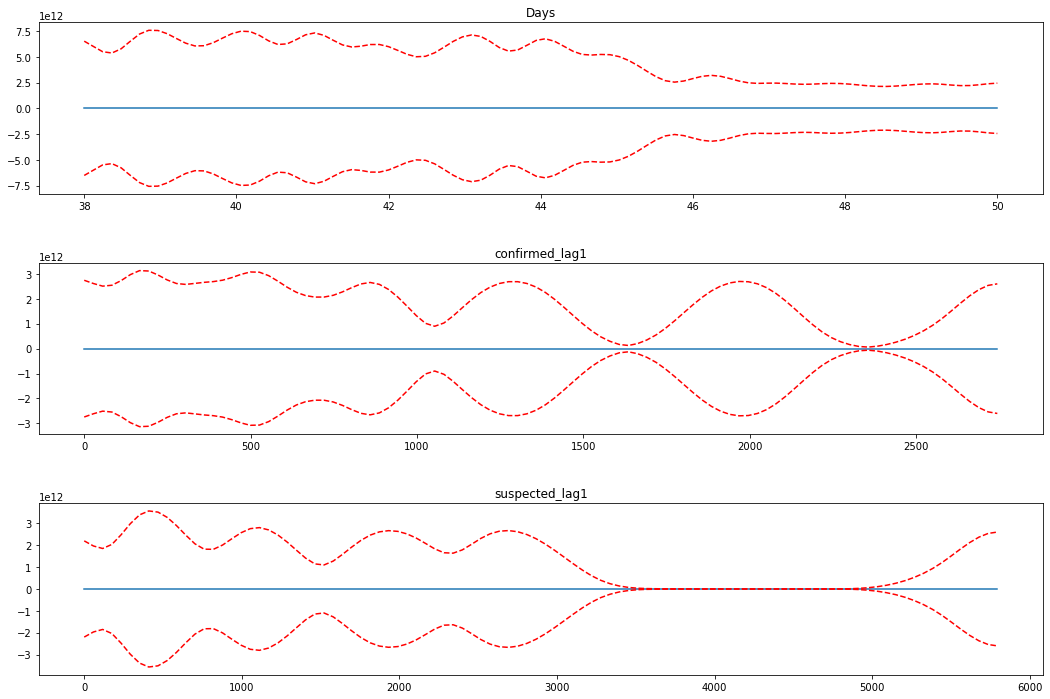

In [12]:
fit_pygam_model(X_train, X_test, y_train, y_test)

### Case 2: Hubei 

In [15]:
Hubei= get_province_df(df, "Hubei Province")

features_to_engineer = ['confirmed'] ## suspected column is not complete

Hubei_df = feature_engineering(Hubei, features_to_engineer)
Train, Test = split_train_test_by_date(Hubei_df, 0.5)
X_train = Train.loc[:,['Days']+[x+'_lag1' for x in features_to_engineer]]
y_train = Train['confirmed']
X_test =  Test.loc[:,['Days']+[x+'_lag1' for x in features_to_engineer]]
y_test = Test['confirmed']

Train dataset: data before 2020-01-28 00:00:00 
Test dataset: the last 14.0 days


100% (187 of 187) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.8826
Link Function:                     IdentityLink Log Likelihood:                                   -80.3951
Number of Samples:                           13 AIC:                                              188.5556
                                                AICc:                                             -30.9346
                                                GCV:                                               11.6421
                                                Scale:                                            193.5005
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

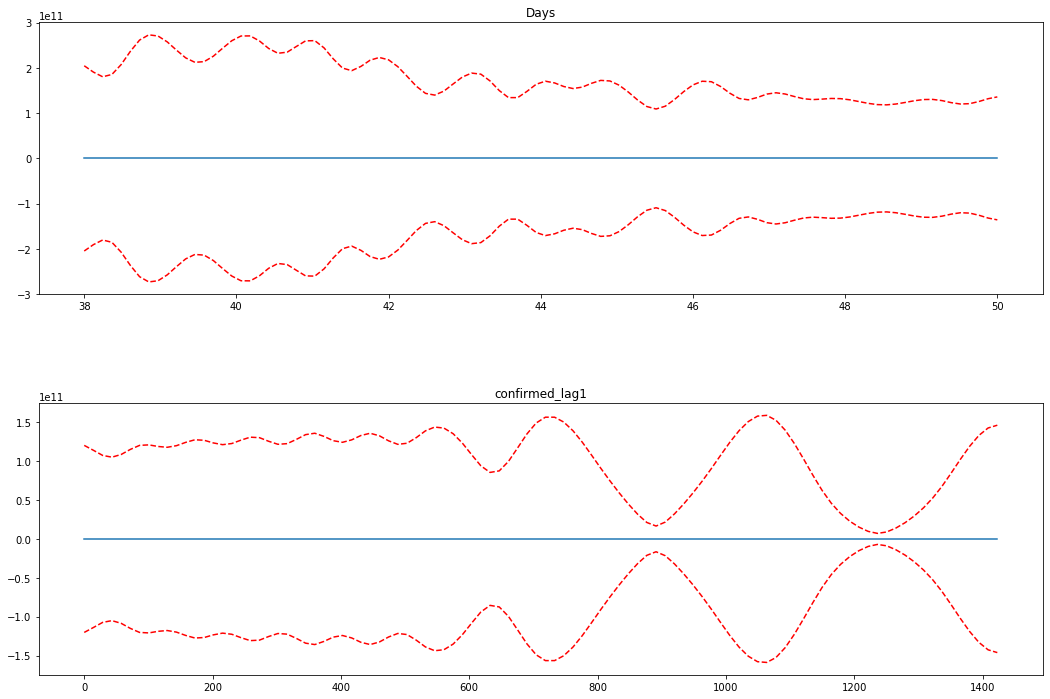

In [16]:
fit_pygam_model(X_train, X_test, y_train, y_test)

### Case 3: Ex-Hubel 

In [17]:
NotHubei= df[(df['province']!="Hubei Province") & (df['province'].isnull()) 
                   & (df['countryCode']=='CN') ]

features_to_engineer = ['confirmed'] ## suspected column is not complete

NotHubei_df = feature_engineering(NotHubei, features_to_engineer)
Train, Test = split_train_test_by_date(NotHubei_df, 0.5)
X_train = Train.loc[:,['Days']+[x+'_lag1' for x in features_to_engineer]]
y_train = Train['confirmed']
X_test =  Test.loc[:,['Days']+[x+'_lag1' for x in features_to_engineer]]
y_test = Test['confirmed']

Train dataset: data before 2020-01-28 00:00:00 
Test dataset: the last 14.0 days


100% (187 of 187) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      12.882
Link Function:                     IdentityLink Log Likelihood:                                    -93.506
Number of Samples:                           13 AIC:                                               214.776
                                                AICc:                                              -4.7649
                                                GCV:                                               32.0889
                                                Scale:                                               530.5
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

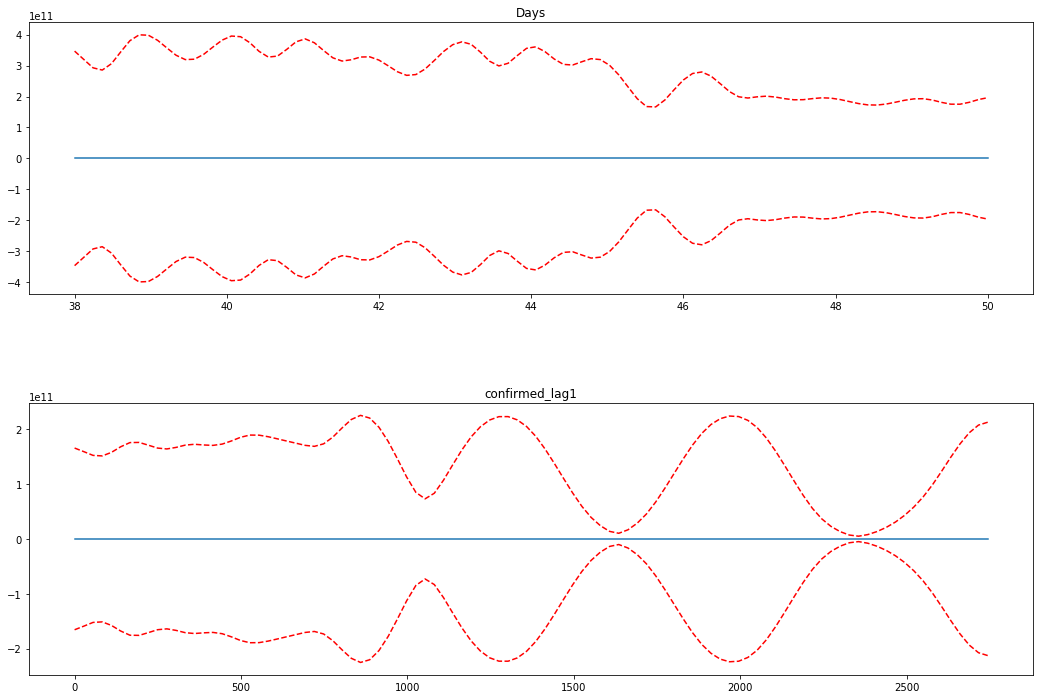

In [18]:
fit_pygam_model(X_train, X_test, y_train, y_test)